# PEtab import

This illustrates how the PEtab format can be used together with the ODE simulation toolbox AMICI to define ODE based parameter estimation problems for pyABC.

To use this functionality, you need to have (at least) PEtab and AMICI installed. You can obtain these by installing pyABC with

    pip install pyabc[amici-petab]
    
or installing them manually via

    pip install petab amici

In [1]:
import petab
import pyabc
import amici.petab_import
from pyabc.petab import AmiciPetabImporter
import numpy as np
import os

os.environ["OMP_NUM_THREADS"] = "1"

We illustrate the usage of PEtab models using a model taken from the benchmark collection. Uncomment the following cell to clone the git repository.

In [2]:
!git clone --depth 1 https://github.com/LeonardSchmiester/Benchmark-Models.git \
    tmp/benchmark-models || (cd tmp/benchmark-models && git pull)

Cloning into 'tmp/benchmark-models'...
remote: Enumerating objects: 3511, done.
remote: Counting objects: 100% (3511/3511), done.
remote: Compressing objects: 100% (922/922), done.
remote: Total 3511 (delta 2695), reused 3170 (delta 2564), pack-reused 0
Receiving objects: 100% (3511/3511), 201.90 MiB | 20.18 MiB/s, done.
Resolving deltas: 100% (2695/2695), done.
Checking out files: 100% (3411/3411), done.


Now we can import a problem, here using the "Boehm_JProteomer2014" example, to AMICI and PEtab:

In [3]:
# read the petab problem from yaml
petab_problem = petab.Problem.from_yaml(
    "tmp/benchmark-models/hackathon_contributions_new_data_format/"
    "Boehm_JProteomeRes2014/Boehm_JProteomeRes2014.yaml")

# compile the petab problem to an AMICI ODE model
model = amici.petab_import.import_petab_problem(petab_problem)

# the solver to numerically solve the ODE
solver = model.getSolver()

# import everything to pyABC
importer = AmiciPetabImporter(petab_problem, model, solver)

# extract what we need from the importer
prior = importer.create_prior()
model = importer.create_model()
kernel = importer.create_kernel()

Once everything has been compiled and imported, we can simply call the model:

In [4]:
model(petab_problem.x_nominal_free_scaled)

{'llh': -138.2219957033097}

By default, this only returns the log likelihood value. If falso simulated data are to be returned (and stored in the pyABC datastore), pass `store_simulations=True` to the importer.

That's all. Now we can run an analysis using pyABC's exact sequential sampler under the assumption of measurement noise, see [this preprint](https://www.biorxiv.org/content/10.1101/2020.01.30.927004v1.abstract) for details. Note that the following cell takes, depending on the resources, minutes to hours to run through.

In [6]:
# this takes some time

sampler = pyabc.MulticoreEvalParallelSampler(n_procs=20)

temperature = pyabc.Temperature()
acceptor = pyabc.StochasticAcceptor(
    pdf_norm_method = pyabc.ScaledPDFNorm())

abc = pyabc.ABCSMC(model, prior, kernel, 
                   eps=temperature,
                   acceptor=acceptor,
                   sampler=sampler,
                   population_size=1000)
abc.new("sqlite:///tmp/petab_amici_boehm.db", {})
abc.run()

INFO:Sampler:Parallelizing the sampling on 20 cores.
INFO:History:Start <ABCSMC(id=1, start_time=2020-02-17 22:35:38.746712, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 49386005.386943504.
INFO:ABC:Acceptance rate: 1000 / 3348 = 2.9869e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 3707.524037573809.
INFO:ABC:Acceptance rate: 1000 / 3582 = 2.7917e-01, ESS=3.0162e+02.
INFO:ABC:t: 2, eps: 189.0069260595768.
INFO:ABC:Acceptance rate: 1000 / 3753 = 2.6645e-01, ESS=2.9065e+02.
INFO:ABC:t: 3, eps: 94.5034630297884.
INFO:ABC:Acceptance rate: 1000 / 6376 = 1.5684e-01, ESS=3.2931e+02.
INFO:ABC:t: 4, eps: 47.2517315148942.
INFO:ABC:Acceptance rate: 1000 / 16933 = 5.9056e-02, ESS=2.7417e+02.
INFO:ABC:t: 5, eps: 23.6258657574471.
INFO:ABC:Acceptance rate: 1000 / 6990 = 1.4306e-01, ESS=3.6511e+02.
INFO:ABC:t: 6, eps: 11.81293287872355.
INFO:ABC:Acceptance rate: 1000 / 50479 = 1.9810e-02, ESS=2.3205e+02.
INFO:ABC:t: 7, eps: 5.906466439361775.
INFO:ABC:Acceptance rate: 1000 

Now we can use pyABC's standard analysis and visualization routines to analyze the obtained posterior sample. In particular, we can extract boundaries and literature parameter values from the PEtab problem:

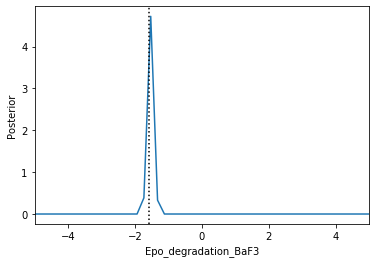

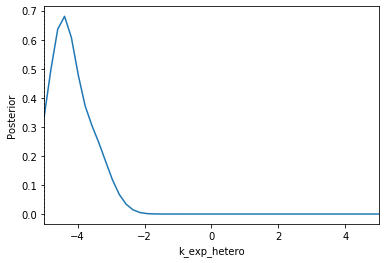

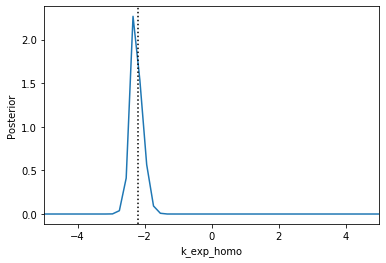

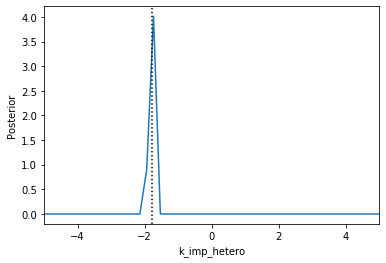

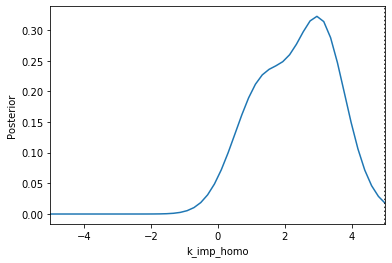

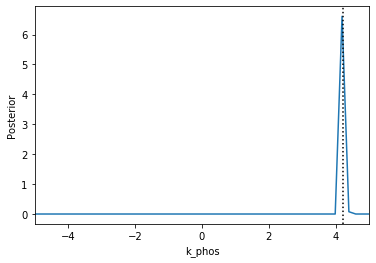

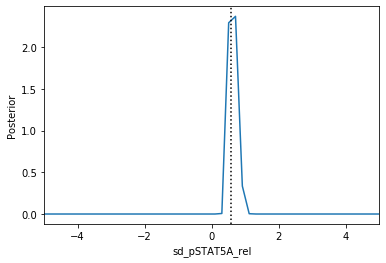

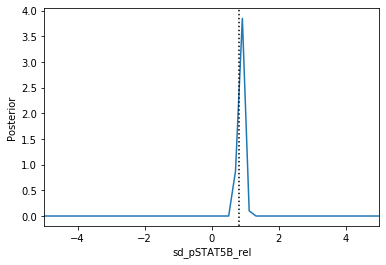

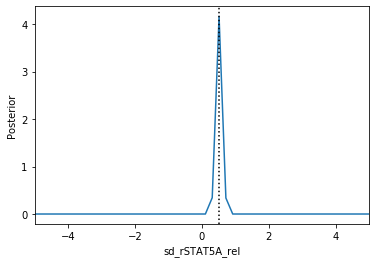

In [7]:
h = pyabc.History("sqlite:///tmp/petab_amici_boehm.db", _id=1)
pdf = petab_problem.parameter_df
refval = {k: v for k,v in zip(petab_problem.x_free_ids, petab_problem.x_nominal_free_scaled)}
for i, par in enumerate(petab_problem.x_free_ids):
    pyabc.visualization.plot_kde_1d_highlevel(
        h, x=par,
        xmin=petab_problem.get_lb(scaled=True,fixed=False)[i],
        xmax=petab_problem.get_ub(scaled=True,fixed=False)[i],
        refval=refval, refval_color='k')

Apparently, in this case seven out of the nine parameters can be estimated with high confidence, while two other parameters can only be bounded.